# Information Retrieval

In [1]:
import ParserCACM
import TextRepresenter
import indexation
import modeles
from query import QueryParserCACM
import evaluation
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import operator
# Auto reload the imported modules when running cells
%load_ext autoreload 
%autoreload 2

""" Some info to remember when testing:
- Query 10 is about parallel computation
- Doc 46 is about parallelism too
"""

# Constants:
srcFolder = "cacm/" 
srcFile = "cacm.txt"
qryFile = "cacm.qry"
relFile = "cacm.rel"
gendata = "gendata" #output folder
indexName = "cacm"

cacm_txt = os.path.join(srcFolder, srcFile)
cacm_qry = os.path.join(srcFolder, qryFile)
cacm_rel = os.path.join(srcFolder, relFile)

##  Indexing:

In [2]:
# Construct the index:
idx = indexation.Index(indexName, gendata)
stemmer = TextRepresenter.PorterStemmer()
parser = ParserCACM.ParserCACM()
idx.indexation(cacm_txt, parser, stemmer, verbose=True)
N_docs = len(idx.getDocsID())
print("Successfully indexed %d documents" % N_docs)

Performing the indexation...
1st pass: build the index...
2nd pass: build the inverted index...
Finished.
Successfully indexed 3204 documents


## Testing precision/recall measure:



###### Testing evaluation.PrecisionRecallMeasure: ###### 
Searching for query # [7, 29, 30]

Query: Query {id=7, txt='I am interested in distributed algorithms - concurrent programs in
which processes communicate and synchronize by using message passing.
Areas of particular interest include fault-tolerance and techniques
for understanding the correctness of these algorithms.
', relevances=[1198, 1338, 1877, 1960, 2150, 2228, 2256, 2280, 2320, 2342, 2376, 2482, 2578, 2597, 2618, 2685, 2700, 2777, 2865, 2866, 2895, 2912, 2941, 3043, 3082, 3128, 3141, 3148]}
Retrieve scores...
This query has 28 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.035714
    2|   2 | 1.000000  |0.071429
    4|   3 | 0.750000  |0.107143
   12|   4 | 0.333333  |0.142857
   13|   5 | 0.384615  |0.178571
   19|   6 | 0.315789  |0.214286
   21|   7 | 0.333333  |0.250000
   31|   8 | 0.258065  |0.285714
   32|   9 | 0.281250  |0.321429
   45|  10 | 0.222222  |0.357143
   49|  11 | 0.224490

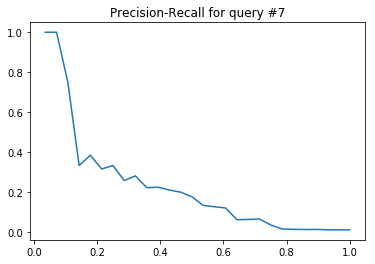

--------------------

Query: Query {id=29, txt='Number-theoretic algorithms, especially involving prime number series,
sieves, and Chinese Remainder theorem.
', relevances=[377, 513, 610, 935, 1094, 1420, 1537, 1538, 1539, 1840, 1841, 1967, 2028, 2089, 2120, 2462, 2927, 2932, 3037]}
Retrieve scores...
This query has 19 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.052632
    2|   2 | 1.000000  |0.105263
    3|   3 | 1.000000  |0.157895
    4|   4 | 1.000000  |0.210526
    5|   5 | 1.000000  |0.263158
    6|   6 | 1.000000  |0.315789
    7|   7 | 1.000000  |0.368421
    8|   8 | 1.000000  |0.421053
   10|   9 | 0.900000  |0.473684
   11|  10 | 0.909091  |0.526316
   12|  11 | 0.916667  |0.578947
   13|  12 | 0.923077  |0.631579
   14|  13 | 0.928571  |0.684211
   15|  14 | 0.933333  |0.736842
   17|  15 | 0.882353  |0.789474
   19|  16 | 0.842105  |0.842105
   39|  17 | 0.435897  |0.894737
  171|  18 | 0.105263  |0.947368
  186|  19 | 0.102151  |1.000000


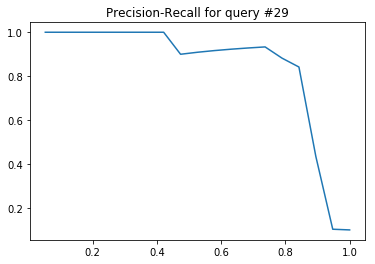

--------------------

Query: Query {id=30, txt='Articles on text formatting systems, including "what you see is what you
get" systems.  Examples: t/nroff, scribe, bravo.
', relevances=[1926, 2486, 2786, 2917]}
Retrieve scores...
This query has 4 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.250000
    6|   2 | 0.333333  |0.500000
   13|   3 | 0.230769  |0.750000
   18|   4 | 0.222222  |1.000000


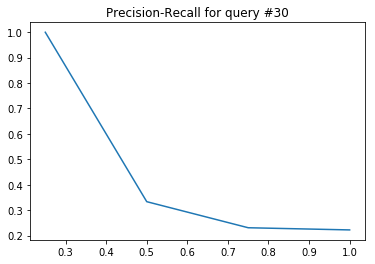

--------------------
Done.


In [3]:
binWeighter = modeles.BinaryWeighter(idx)
tfidfWeighter = modeles.TfidfWeighter(idx)
vect = modeles.Vectoriel(idx, tfidfWeighter)

print("\n###### Testing evaluation.PrecisionRecallMeasure: ###### ")
queryChosen = [7, 29, 30]
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #", queryChosen)
while query is not None :
    if int(query.getID()) in queryChosen:
        print("\nQuery:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        ranking = vect.getRanking(queryTxt)
        irlist = evaluation.IRList(query, ranking)
        precisRecall = evaluation.PrecisionRecallMeasure(irlist)
        pr = precisRecall.eval(verbose=True, nbLevel=100) # (recall, precision)
        precision = [p for r,p in pr]
        recall = [r for r,p in pr]
        plt.plot(recall, precision)
        plt.title("Precision-Recall for query #"+query.getID())
        plt.show()
        print(20*'-')


    query = qp.nextQuery()
print("Done.")


## Testing average precision:

In [4]:
print("\n###### Testing evaluation.AveragePrecision: ###### ")
queryChosen =[9, 10, 14, 29]#, 25, 26, 27, 42, 43] # lots of relevant results
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #",queryChosen, "\n")
while query is not None :
    if int(query.getID()) in queryChosen:
        print("Query:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        scores = vect.getRanking(queryTxt)
        irlist = evaluation.IRList(query, scores)
        average_measure = evaluation.AveragePrecision(irlist)
        print("Evaluate the scores.")
        average_prec = average_measure.eval(verbose=True)
        print("Average precision: %f" % average_prec)
        print(20*'-')

    query = qp.nextQuery()



###### Testing evaluation.AveragePrecision: ###### 
Searching for query # [9, 10, 14, 29] 

Query: Query {id=9, txt='Security considerations in local networks, network operating systems,
and distributed systems.
', relevances=[2372, 2632, 2870, 2876, 3068, 3111, 3128, 3158, 3177]}
Retrieve scores...
Evaluate the scores.
This query has 9 relevant results
   i |found| precision
    1|   1 | 1.000000
    2|   2 | 1.000000
    3|   3 | 1.000000
    4|   4 | 1.000000
    6|   5 | 0.833333
   33|   6 | 0.181818
   71|   7 | 0.098592
  111|   8 | 0.072072
  311|   9 | 0.028939
Average precision: 0.579417
--------------------
Query: Query {id=10, txt='Parallel languages; languages for parallel computation
', relevances=[46, 141, 392, 950, 1158, 1198, 1262, 1380, 1471, 1601, 1613, 1747, 1795, 1811, 2060, 2150, 2256, 2289, 2342, 2376, 2433, 2618, 2664, 2685, 2700, 2714, 2777, 2785, 2851, 2895, 2896, 2912, 3039, 3075, 3156]}
Retrieve scores...
Evaluate the scores.
This query has 35 relevant resu

## Testing EvalIRModel:

In [5]:
print("\n###### Testing evaluation.EvalIRModel: ###### ")
queryChosen = np.random.randint(1, 64, size=10)
#queryChosen =[7, 10, 14]#, 25, 26, 27, 42, 43] # lots of relevant results
queries = []
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for queries #",queryChosen, "...")
while query is not None :
    if int(query.getID()) in queryChosen:
        queries.append(query)
    query = qp.nextQuery()
print("Found queries")
irmodels = {"vectoriel_tfidf": modeles.Vectoriel(idx, tfidfWeighter),
            "vectoriel_bw": modeles.Vectoriel(idx, binWeighter)
           }
measures = {"averagePrecision": evaluation.AveragePrecision}
eval_model = evaluation.EvalIRModel(queries, irmodels, measures)
print("Calling eval()...")
print(eval_model.eval(verbose=False))
print("Done.")



###### Testing evaluation.EvalIRModel: ###### 
Searching for queries # [13 43 13 63 37 56 41 17 34  1] ...
Found queries
Calling eval()...
{('vectoriel_tfidf', 'averagePrecision'): (0.12630620697924713, 0.12828306303614209), ('vectoriel_bw', 'averagePrecision'): (0.090068916596127258, 0.093620194216179023)}
Done.


## Comparison of language models:

In [29]:
from sklearn.model_selection import train_test_split

# Searching queries:
queries = []
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
queryChosen = list(range(1, 50)) # lots of relevant results

print("Searching for queries #",queryChosen, "...")
while query is not None :
    if int(query.getID()) in queryChosen:
        queries.append(query)
    query = qp.nextQuery()
print("Found all queries")

q_train, q_test = train_test_split(queries)

# Train models, find best parameters.
unigram_params_grid = {'index':[idx], 'regularization':np.linspace(0,1, 20, endpoint=False)}

#c = dict_combinations(params_grid)
#print("comb: ",c)

best_unigram_params = {'index':idx, 'regularization':0.6842105263157893}
#best_unigram_params = evaluation.gridsearch(modeles.UnigramLanguage, unigram_params_grid, 
#                 q_train, evaluation.AveragePrecision, verbose=1)
print("Best unigram params:", best_unigram_params)

Searching for queries # [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49] ...
Found all queries
Best unigram params: {'index': <indexation.Index object at 0x7f0798e79f98>, 'regularization': 0.3684210526315789}


In [33]:
okapi_params_grid = {'index':[idx], 'k':np.linspace(1, 2, 10), 'b':np.linspace(0,2,10)}

best_okapi_params = {'index':idx, 'k': 1.1111111111111112, 'b': 0.6}
#best_okapi_params = evaluation.gridsearch(modeles.Okapi, okapi_params_grid, 
#             q_train, evaluation.AveragePrecision, verbose=1)

print("Best okapi params:", best_okapi_params)

Best okapi params: {'k': 1.1111111111111112, 'b': 0.6, 'index': <indexation.Index object at 0x7f0798e79f98>}


### Execution on the test set:

In [34]:
print("best unigram params:", best_unigram_params)
print("best okapi params:", best_okapi_params)

irmodels = {'unigram':modeles.UnigramLanguage(**best_unigram_params),
            'okapi':modeles.Okapi(**best_okapi_params)}

eval_models = evaluation.EvalIRModel(q_test, irmodels, {'measure':evaluation.AveragePrecision})
scores = eval_models.eval(verbose=True)
print(scores)

best unigram params: {'index': <indexation.Index object at 0x7f0798e79f98>, 'regularization': 0.3684210526315789}
best okapi params: {'k': 1.1111111111111112, 'b': 0.6, 'index': <indexation.Index object at 0x7f0798e79f98>}
[  0/  2] IRModel 'okapi'
Measure: measure
(0.42534931104965679, 0.24053126649934967)
[  1/  2] IRModel 'unigram'
Measure: measure
(0.44673985979448089, 0.21745929409528778)
{('unigram', 'measure'): (0.44673985979448089, 0.21745929409528778), ('okapi', 'measure'): (0.42534931104965679, 0.24053126649934967)}


In [9]:
print("\n###### Comparison of different models: ###### ")
queryChosen = np.random.randint(1, 64, size=5)
queries = []
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for queries #",queryChosen, "...")
while query is not None :
    if int(query.getID()) in queryChosen:
        queries.append(query)
    query = qp.nextQuery()
print("Found queries")
irmodels = {"vectoriel_tfidf": modeles.Vectoriel(idx, tfidfWeighter),
            "vectoriel_bw": modeles.Vectoriel(idx, binWeighter),
            'unigram':modeles.UnigramLanguage(**best_unigram_params),
            'okapi':modeles.Okapi(**best_okapi_params)
           }
measures = {"averagePrecision": evaluation.AveragePrecision}
eval_model = evaluation.EvalIRModel(queries, irmodels, measures)
print("Calling eval()...")
print(eval_model.eval(verbose=False))
print("Done.")



###### Comparison of different models: ###### 
Searching for queries # [56  1 48 55 45] ...
Found queries
Calling eval()...
{('vectoriel_tfidf', 'averagePrecision'): (0.12046585073226537, 0.13644632545756047), ('unigram', 'averagePrecision'): (0.18697330505583781, 0.16482483970226861), ('okapi', 'averagePrecision'): (0.14960355264280056, 0.17212530898646577), ('vectoriel_bw', 'averagePrecision'): (0.12294950647422449, 0.12888086852492672)}
Done.


## PageRank


###### Testing evaluation.PrecisionRecallMeasure: ###### 
Searching for query # [7, 29, 30]

Query: Query {id=7, txt='I am interested in distributed algorithms - concurrent programs in
which processes communicate and synchronize by using message passing.
Areas of particular interest include fault-tolerance and techniques
for understanding the correctness of these algorithms.
', relevances=[1198, 1338, 1877, 1960, 2150, 2228, 2256, 2280, 2320, 2342, 2376, 2482, 2578, 2597, 2618, 2685, 2700, 2777, 2865, 2866, 2895, 2912, 2941, 3043, 3082, 3128, 3141, 3148]}
Retrieve scores...
219 nodes in the sub-graph
This query has 28 relevant results
   i |found| precision | recall
    5|   1 | 0.200000  |0.035714
    6|   2 | 0.333333  |0.071429
   10|   3 | 0.300000  |0.107143
   13|   4 | 0.307692  |0.142857
   30|   5 | 0.166667  |0.178571
   49|   6 | 0.122449  |0.214286
   81|   7 | 0.086420  |0.250000
   87|   8 | 0.091954  |0.285714
   92|   9 | 0.097826  |0.321429
   93|  10 | 0.107527  |0.3

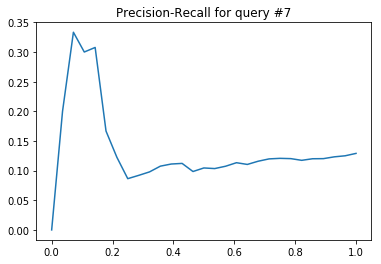

--------------------

Query: Query {id=29, txt='Number-theoretic algorithms, especially involving prime number series,
sieves, and Chinese Remainder theorem.
', relevances=[377, 513, 610, 935, 1094, 1420, 1537, 1538, 1539, 1840, 1841, 1967, 2028, 2089, 2120, 2462, 2927, 2932, 3037]}
Retrieve scores...
64 nodes in the sub-graph
This query has 19 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.052632
    2|   2 | 1.000000  |0.105263
    3|   3 | 1.000000  |0.157895
    4|   4 | 1.000000  |0.210526
    7|   5 | 0.714286  |0.263158
   14|   6 | 0.428571  |0.315789
   15|   7 | 0.466667  |0.368421
   21|   8 | 0.380952  |0.421053
   24|   9 | 0.375000  |0.473684
   25|  10 | 0.400000  |0.526316
   45|  11 | 0.244444  |0.578947
   46|  12 | 0.260870  |0.631579
   47|  13 | 0.276596  |0.684211
   48|  14 | 0.291667  |0.736842
   49|  15 | 0.306122  |0.789474
   50|  16 | 0.320000  |0.842105
   51|  17 | 0.333333  |0.894737
   53|  18 | 0.339623  |0.947368
   54|  19

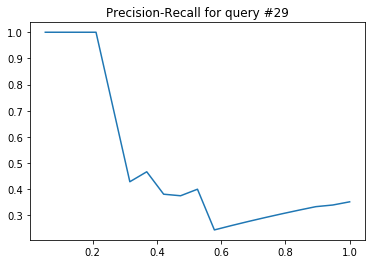

--------------------

Query: Query {id=30, txt='Articles on text formatting systems, including "what you see is what you
get" systems.  Examples: t/nroff, scribe, bravo.
', relevances=[1926, 2486, 2786, 2917]}
Retrieve scores...
187 nodes in the sub-graph
This query has 4 relevant results
   i |found| precision | recall
   27|   1 | 0.037037  |0.250000
  169|   2 | 0.011834  |0.500000
  175|   3 | 0.017143  |0.750000
  177|   4 | 0.022599  |1.000000


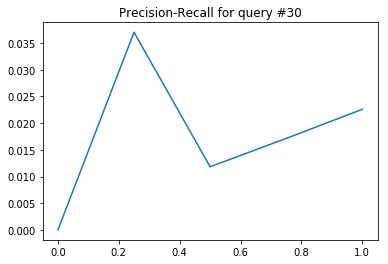

--------------------
Done.


In [10]:
pagerank_model = modeles.PageRankModel(idx, baseModel=vect, seedsNbr=20, parentsNbr=3)

print("\n###### Testing evaluation.PrecisionRecallMeasure: ###### ")
queryChosen = [7, 29, 30]
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #", queryChosen)
while query is not None :
    if int(query.getID()) in queryChosen:
        print("\nQuery:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        ranking = pagerank_model.getRanking(queryTxt)
        irlist = evaluation.IRList(query, ranking)
        precisRecall = evaluation.PrecisionRecallMeasure(irlist)
        pr = precisRecall.eval(verbose=True, nbLevel=100) # (recall, precision)
        precision = [p for r,p in pr]
        recall = [r for r,p in pr]
        plt.plot(recall, precision)
        plt.title("Precision-Recall for query #"+query.getID())
        plt.show()
        print(20*'-')


    query = qp.nextQuery()
print("Done.")


In [11]:
print("\n###### Testing evaluation.AveragePrecision: ###### ")
queryChosen =[9, 10, 14, 29]#, 25, 26, 27, 42, 43] # lots of relevant results
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #",queryChosen, "\n")
while query is not None :
    if int(query.getID()) in queryChosen:
        print("Query:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        scores = pagerank_model.getRanking(queryTxt)
        irlist = evaluation.IRList(query, scores)
        average_measure = evaluation.AveragePrecision(irlist)
        print("Evaluate the scores.")
        average_prec = average_measure.eval(verbose=True)
        print("Average precision: %f" % average_prec)
        print(20*'-')

    query = qp.nextQuery()



###### Testing evaluation.AveragePrecision: ###### 
Searching for query # [9, 10, 14, 29] 

Query: Query {id=9, txt='Security considerations in local networks, network operating systems,
and distributed systems.
', relevances=[2372, 2632, 2870, 2876, 3068, 3111, 3128, 3158, 3177]}
Retrieve scores...
110 nodes in the sub-graph
Evaluate the scores.
This query has 9 relevant results
   i |found| precision
    5|   1 | 0.200000
    8|   2 | 0.250000
   28|   3 | 0.107143
   61|   4 | 0.065574
   70|   5 | 0.071429
   80|   6 | 0.075000
   84|   7 | 0.083333
   94|   8 | 0.085106
  100|   8 | 0.080000
  102|   9 | 0.088235
Average precision: 0.122869
--------------------
Query: Query {id=10, txt='Parallel languages; languages for parallel computation
', relevances=[46, 141, 392, 950, 1158, 1198, 1262, 1380, 1471, 1601, 1613, 1747, 1795, 1811, 2060, 2150, 2256, 2289, 2342, 2376, 2433, 2618, 2664, 2685, 2700, 2714, 2777, 2785, 2851, 2895, 2896, 2912, 3039, 3075, 3156]}
Retrieve scores...
242

In [14]:
pagerank_params_grid = {'index':[idx], 
                        'baseModel':[modeles.Vectoriel(idx, tfidfWeighter), modeles.Vectoriel(idx, binWeighter)],
                        'seedsNbr':np.logspace(1, 3, num=3, dtype=int), 
                        'parentsNbr':np.linspace(0, 100, num=3, dtype=int)}

best_pagerank_params = {'index':idx, 'baseModel':modeles.Vectoriel(idx, tfidfWeighter),
                        'seedsNbr':100,
                       'parentsNbr':5}
#best_pagerank_params = evaluation.gridsearch(modeles.PageRankModel, pagerank_params_grid, 
#             q_train, evaluation.AveragePrecision, verbose=1)

print("Best PageRank params:", best_pagerank_params)
pagerank_model = modeles.PageRankModel(**best_pagerank_params)

Best PageRank params: {'parentsNbr': 5, 'baseModel': <modeles.Vectoriel object at 0x7f07667ed828>, 'seedsNbr': 100, 'index': <indexation.Index object at 0x7f0798e79f98>}


## HITS


###### Testing evaluation.PrecisionRecallMeasure: ###### 
Searching for query # [7, 29, 30]

Query: Query {id=7, txt='I am interested in distributed algorithms - concurrent programs in
which processes communicate and synchronize by using message passing.
Areas of particular interest include fault-tolerance and techniques
for understanding the correctness of these algorithms.
', relevances=[1198, 1338, 1877, 1960, 2150, 2228, 2256, 2280, 2320, 2342, 2376, 2482, 2578, 2597, 2618, 2685, 2700, 2777, 2865, 2866, 2895, 2912, 2941, 3043, 3082, 3128, 3141, 3148]}
Retrieve scores...
219 nodes in the sub-graph
This query has 28 relevant results
   i |found| precision | recall
    5|   1 | 0.200000  |0.035714
   75|   2 | 0.026667  |0.071429
   76|   3 | 0.039474  |0.107143
   77|   4 | 0.051948  |0.142857
   78|   5 | 0.064103  |0.178571
   80|   6 | 0.075000  |0.214286
   81|   7 | 0.086420  |0.250000
   85|   8 | 0.094118  |0.285714
   86|   9 | 0.104651  |0.321429
   99|  10 | 0.101010  |0.3

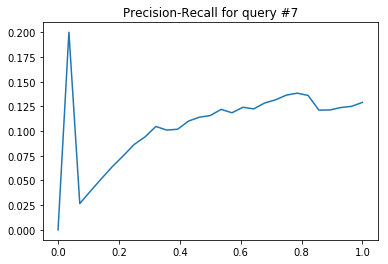

--------------------

Query: Query {id=29, txt='Number-theoretic algorithms, especially involving prime number series,
sieves, and Chinese Remainder theorem.
', relevances=[377, 513, 610, 935, 1094, 1420, 1537, 1538, 1539, 1840, 1841, 1967, 2028, 2089, 2120, 2462, 2927, 2932, 3037]}
Retrieve scores...
64 nodes in the sub-graph
This query has 19 relevant results
   i |found| precision | recall
   29|   1 | 0.034483  |0.052632
   35|   2 | 0.057143  |0.105263
   36|   3 | 0.083333  |0.157895
   37|   4 | 0.108108  |0.210526
   38|   5 | 0.131579  |0.263158
   39|   6 | 0.153846  |0.315789
   40|   7 | 0.175000  |0.368421
   41|   8 | 0.195122  |0.421053
   42|   9 | 0.214286  |0.473684
   43|  10 | 0.232558  |0.526316
   44|  11 | 0.250000  |0.578947
   45|  12 | 0.266667  |0.631579
   46|  13 | 0.282609  |0.684211
   47|  14 | 0.297872  |0.736842
   48|  15 | 0.312500  |0.789474
   49|  16 | 0.326531  |0.842105
   50|  17 | 0.340000  |0.894737
   52|  18 | 0.346154  |0.947368
   53|  19

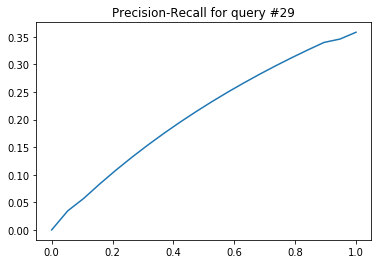

--------------------

Query: Query {id=30, txt='Articles on text formatting systems, including "what you see is what you
get" systems.  Examples: t/nroff, scribe, bravo.
', relevances=[1926, 2486, 2786, 2917]}
Retrieve scores...
187 nodes in the sub-graph
This query has 4 relevant results
   i |found| precision | recall
  103|   1 | 0.009709  |0.250000
  168|   2 | 0.011905  |0.500000
  174|   3 | 0.017241  |0.750000
  176|   4 | 0.022727  |1.000000


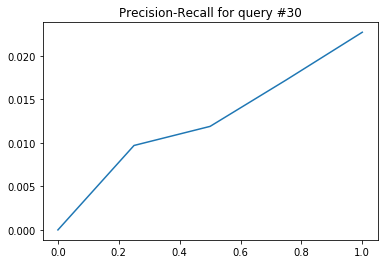

--------------------
Done.


In [16]:
hits_model = modeles.HitsModel(idx, baseModel=vect, seedsNbr=20, parentsNbr=3)

print("\n###### Testing evaluation.PrecisionRecallMeasure: ###### ")
queryChosen = [7, 29, 30]
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #", queryChosen)
while query is not None :
    if int(query.getID()) in queryChosen:
        print("\nQuery:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        ranking = hits_model.getRanking(queryTxt)
        irlist = evaluation.IRList(query, ranking)
        precisRecall = evaluation.PrecisionRecallMeasure(irlist)
        pr = precisRecall.eval(verbose=True, nbLevel=100) # (recall, precision)
        precision = [p for r,p in pr]
        recall = [r for r,p in pr]
        plt.plot(recall, precision)
        plt.title("Precision-Recall for query #"+query.getID())
        plt.show()
        print(20*'-')


    query = qp.nextQuery()
print("Done.")


In [19]:
hits_params_grid = {'index':[idx], 
                        'baseModel':[modeles.Vectoriel(idx, tfidfWeighter), modeles.Vectoriel(idx, binWeighter)],
                        'seedsNbr':[10, 20, 30], 
                        'parentsNbr':[0, 2, 10]}

best_hits_params = {'index':idx, 'baseModel':modeles.Vectoriel(idx, tfidfWeighter),
                        'seedsNbr':100,
                       'parentsNbr':5}

#best_hits_params = evaluation.gridsearch(modeles.HitsModel, hits_params_grid, 
#             q_train, evaluation.AveragePrecision, verbose=1)

print("Best HITS params:", best_hits_params)
hits_model = modeles.HitsModel(**best_hits_params)

Best HITS params: {'parentsNbr': 5, 'baseModel': <modeles.Vectoriel object at 0x7f07667df240>, 'seedsNbr': 100, 'index': <indexation.Index object at 0x7f0798e79f98>}


In [22]:

irmodels = {'pagerank':modeles.PageRankModel(**best_pagerank_params),
            'hits':modeles.HitsModel(**best_hits_params)}
print("Testing on ", q_test)
eval_models = evaluation.EvalIRModel(q_test, irmodels, {'measure':evaluation.AveragePrecision})
scores = eval_models.eval(verbose=True)
print(scores)

Testing on  [<query.Query object at 0x7f0766922668>, <query.Query object at 0x7f0770e16240>, <query.Query object at 0x7f0766922400>]
[  0/  2] IRModel 'pagerank'
577 nodes in the sub-graph
581 nodes in the sub-graph
598 nodes in the sub-graph
Measure: measure
(0.025210259790923062, 0.018090270925010945)
[  1/  2] IRModel 'hits'
577 nodes in the sub-graph
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
581 nodes in the sub-graph
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
598 nodes in the sub-graph
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
Measure: measure
(0.025073432872006737, 0.020728728333908306)
{('pagerank', 'measure'): (0.025210259790923062, 0.018090270925010945), ('hits', 'measure'): (0.025073432872006737, 0.020728728333908306)}


## MetaModel 

In [43]:
import meta
# 3 models:
binWeighter = modeles.BinaryWeighter(idx)
vect_binary = modeles.Vectoriel(idx, binWeighter)
tfidfWeighter = modeles.TfidfWeighter(idx)
vect_tfidf = modeles.Vectoriel(idx, tfidfWeighter)
unigram = modeles.UnigramLanguage(**best_unigram_params)

list_model = [vect_binary, vect_tfidf, unigram]
list_featurers_model = [meta.FeaturerModel(idx, model) for model in list_model]
list_featurers = [meta.DocLenFeaturer(idx), meta.QueryLenFeaturer(idx)] + list_featurers_model
featurers = meta.FeaturerList(idx, list_featurers)
meta_model = meta.MetaModel(idx, featurers, stemmer=stemmer)

print("Train...")
meta_model.train(q_train, max_iter = 30, lr=0.01, regul_coef=2)
print("Done.")

print("\n###### Testing evaluation.AveragePrecision: ###### ")
queryChosen = np.random.randint(1, 50, size=3)
#queryChosen =[7, 10, 14, 29]#, 25, 26, 27, 42, 43] # lots of relevant results
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #",queryChosen, "\n")
while query is not None :
    if int(query.getID()) in queryChosen:
        print("Query:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        scores = meta_model.getRanking(queryTxt)
        irlist = evaluation.IRList(query, scores)
        average_measure = evaluation.AveragePrecision(irlist)
        print("Evaluate the scores.")
        average_prec = average_measure.eval(verbose=True)
        print("Average precision: %f" % average_prec)
        print(20*'-')

    query = qp.nextQuery()
print("Done.")


Featurers: [<meta.DocLenFeaturer object at 0x7f0766567358>, <meta.QueryLenFeaturer object at 0x7f07665677b8>, <meta.FeaturerModel object at 0x7f07665670b8>, <meta.FeaturerModel object at 0x7f07665676a0>, <meta.FeaturerModel object at 0x7f0766567c50>]
Train...
Done.

###### Testing evaluation.AveragePrecision: ###### 
Searching for query # [48 14  5] 

Query: Query {id=5, txt='I'd like papers on design and implementation of editing interfaces,
window-managers, command interpreters, etc.  The essential issues are
human interface design, with views on improvements to user efficiency,
effectiveness and satisfaction.
', relevances=[756, 1307, 1502, 2035, 2299, 2399, 2501, 2820]}
Retrieve scores...
Evaluate the scores.
This query has 8 relevant results
   i |found| precision
   11|   1 | 0.090909
   12|   2 | 0.166667
   14|   3 | 0.214286
   59|   4 | 0.067797
  158|   5 | 0.031646
  166|   6 | 0.036145
  245|   7 | 0.028571
  275|   8 | 0.029091
Average precision: 0.083139
----------------

In [42]:

irmodels = {'okapi':modeles.Okapi(**best_okapi_params),
            'vectoriel tfidf':modeles.Vectoriel(idx, tfidfWeighter),
             'metamodel':meta_model}
print("Testing on %d queries" % len(q_test))
eval_models = evaluation.EvalIRModel(q_test, irmodels, {'measure':evaluation.AveragePrecision})
scores = eval_models.eval(verbose=True)
print(scores)

Testing on 13 queries
[  0/  3] IRModel 'vectoriel tfidf'
Measure: measure
(0.34530784767296796, 0.26687580930578647)
[  1/  3] IRModel 'metamodel'
Measure: measure
(0.44687399015661422, 0.21751796837326173)
[  2/  3] IRModel 'okapi'
Measure: measure
(0.42534931104965679, 0.24053126649934967)
{('metamodel', 'measure'): (0.44687399015661422, 0.21751796837326173), ('vectoriel tfidf', 'measure'): (0.34530784767296796, 0.26687580930578647), ('okapi', 'measure'): (0.42534931104965679, 0.24053126649934967)}
